### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

color_pallete =sns.color_palette()
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df_train =pd.read_csv('/content/DailyDelhiClimateTrain.csv',index_col='date',parse_dates=True)
# df_test =pd.read_csv('/content/DailyDelhiClimateTest.csv',index_col='date',parse_dates=True)

In [3]:
df_train.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1462 entries, 2013-01-01 to 2017-01-01
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      1462 non-null   float64
 1   humidity      1462 non-null   float64
 2   wind_speed    1462 non-null   float64
 3   meanpressure  1462 non-null   float64
dtypes: float64(4)
memory usage: 57.1 KB


In [ ]:
df_train.shape  #,df_test.shape

((1462, 4), (114, 4))

In [6]:
df_train.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1011.104548
std,7.348103,16.769652,4.561602,180.231668
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.580357
50%,27.714286,62.625000,6.221667,1008.563492
75%,31.305804,72.218750,9.238235,1014.944901
max,38.714286,100.000000,42.220000,7679.333333


### EDA

### Decomposition of Time Series
Any time series distribution has 3 core components:

- Seasonality - does the data have a clear cyclical/periodic pattern?
- Trend - does the data represent a general upward or downward slope?
- Noise - what are the outliers or missing values that are not consistent with the rest of the data?

array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>], dtype=object)

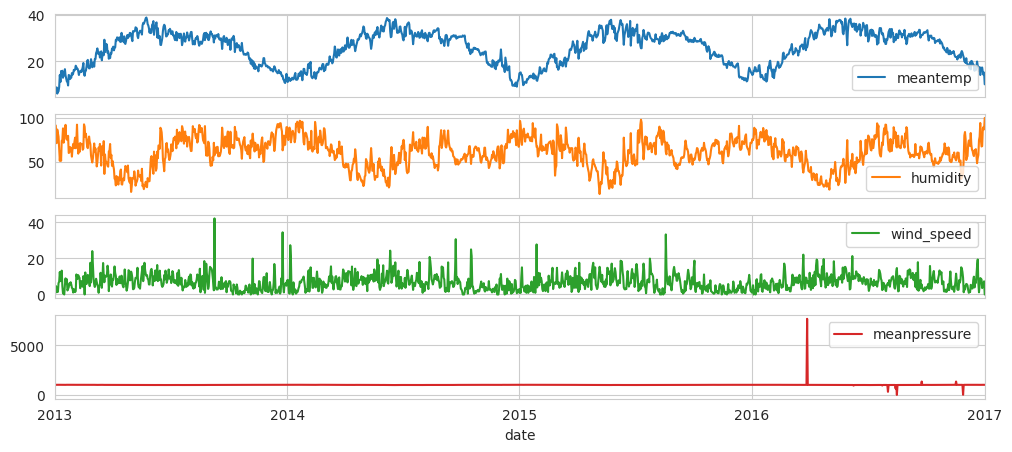

In [7]:
df =df_train.copy()
df.plot(subplots=True,sharex=True,figsize=(12,5))


thier is yearly seasonal and anomly in meanpressure

## Outlier Handling

In [8]:
df['meanpressure'].describe()

,meanpressure
count,1462.000000
mean,1011.104548
std,180.231668
min,-3.041667
25%,1001.580357
50%,1008.563492
75%,1014.944901
max,7679.333333


**Lowerst pressure record in the world is 870 and highest is 1084**

so I will replace the outliers with mean of the cleaned dataframe

In [9]:
df_error =df[(df['meanpressure']<870) | (df['meanpressure'] > 1084)]
df_error

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2016-03-28,25.933333,52.800000,6.546667,7679.333333
2016-08-02,30.687500,72.125000,6.375000,310.437500
2016-08-14,28.933333,83.700000,6.370000,633.900000
2016-08-16,31.333333,66.416667,14.666667,-3.041667
2016-09-24,31.240000,66.480000,5.496154,1352.615385
2016-11-17,21.730769,51.730769,11.550000,1350.296296
2016-11-28,22.454545,37.318182,9.185714,12.045455


In [10]:
# dataframes without errors to get means
df_cleaned =df.drop(df_error.index,axis=0)

# get mean
mean_pressure =df_cleaned['meanpressure'].mean()

# replace outliers with mean
df.loc[df_error.index,'meanpressure'] =mean_pressure
df.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1008.178187
std,7.348103,16.769652,4.561602,7.808525
min,6.000000,13.428571,0.000000,938.066667
25%,18.857143,50.375000,3.475000,1001.625000
50%,27.714286,62.625000,6.221667,1008.500000
75%,31.305804,72.218750,9.238235,1014.875000
max,38.714286,100.000000,42.220000,1023.000000


array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>], dtype=object)

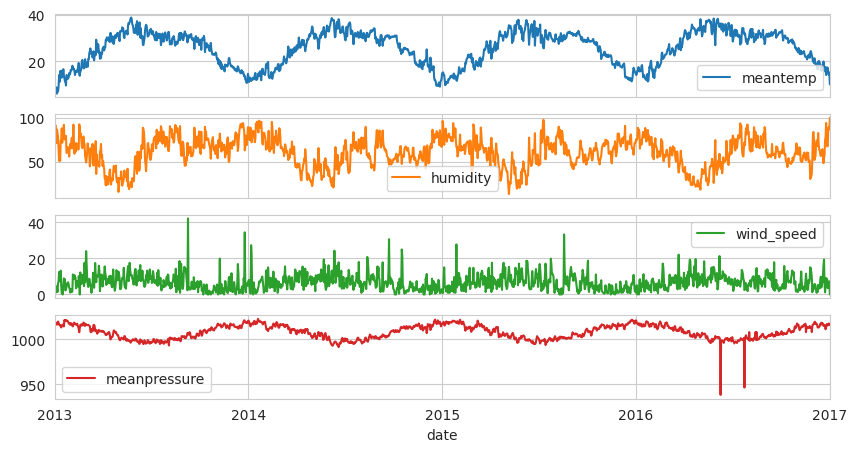

In [11]:
df.plot(sharex=True,figsize=(10,5),subplots=True)

Text(0.5, 1.0, 'Meanpressure after cleaning')

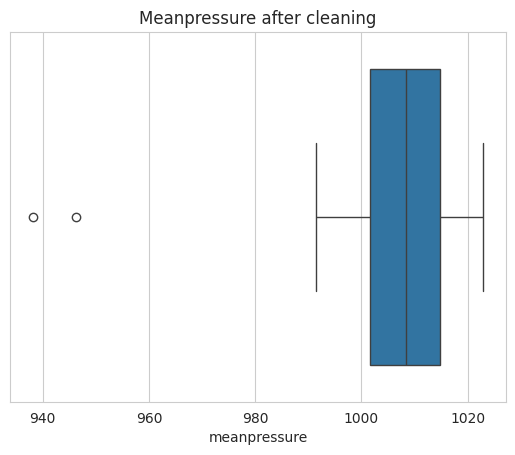

In [12]:
sns.boxplot(df,x='meanpressure')
plt.title('Meanpressure after cleaning')

array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>], dtype=object)

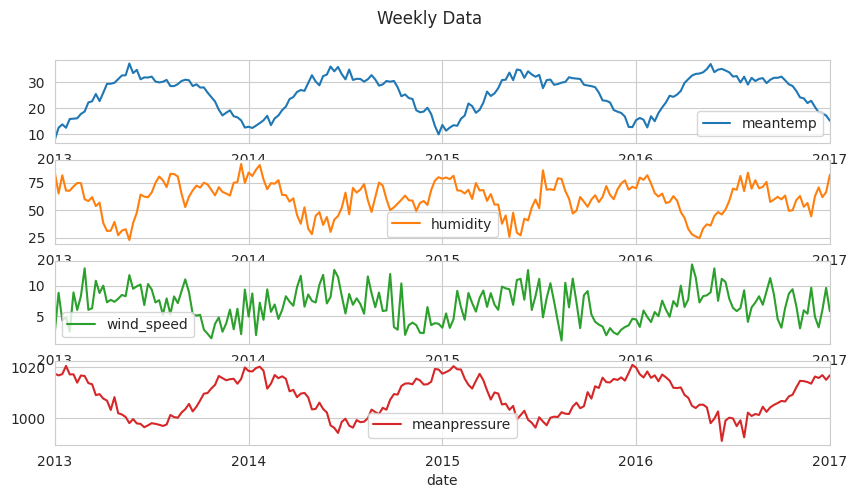

In [13]:
# create weekly and month time frame
df_weekly =df.resample(rule='W').mean()
df_monthly =df.resample(rule='M').mean()

df_weekly.plot(subplots=True,figsize=(10,5),title="Weekly Data",sharex=False)

array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>], dtype=object)

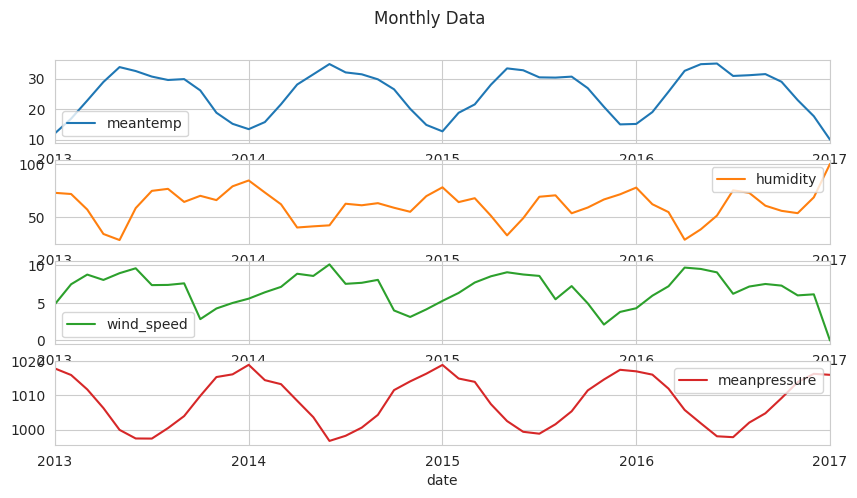

In [14]:
df_monthly.plot(subplots=True,figsize=(10,5),title="Monthly Data",sharex=False)

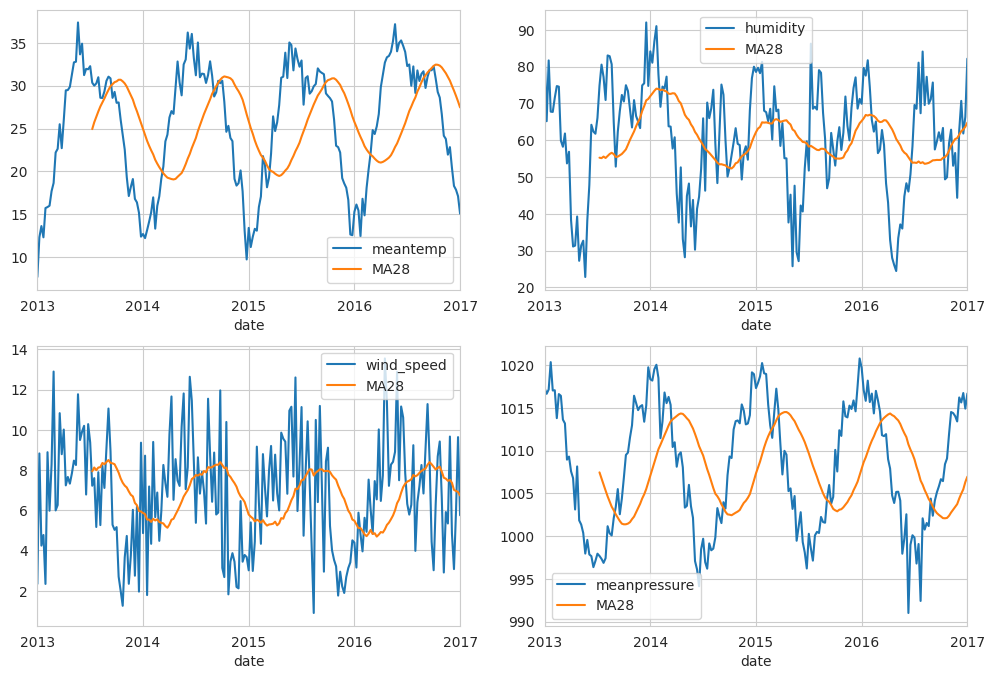

In [15]:
# drew weekly data with thier trends(moving average with window size = 28)
MA28 =df_weekly.rolling(28).mean()

fig,ax =plt.subplots(nrows=2,ncols=2,figsize=(12,8))

for ax,col in zip(ax.flat,df.columns):
  df_weekly[col].plot(ax=ax,label =col)
  MA28[col].plot(ax=ax,label='MA28')
  ax.legend()

## Seasonality

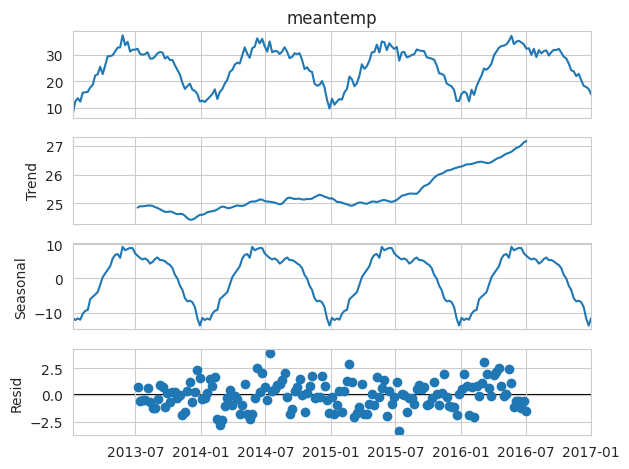

In [16]:
res =seasonal_decompose(df_weekly['meantemp'])
res.plot()
plt.show()

- Strong seasonality: Temperature fluctuates in a yearly cycle.
- Gradual warming trend: An increase in average temperature after 2015.
- Well-behaved residuals: No major anomalies, indicating a good model fit.

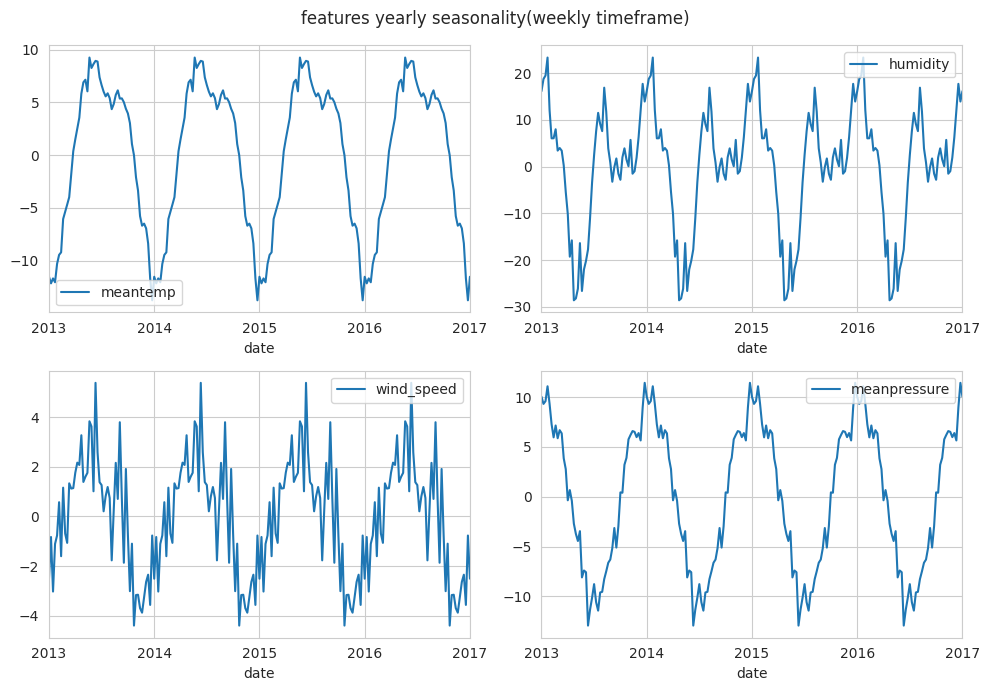

In [17]:
# plot seasonality for all cols
fig,ax =plt.subplots(nrows=2,ncols=2,figsize=(10,7))

for ax,col in zip(ax.flat,df_weekly.columns):
  decompose=seasonal_decompose(df_weekly[col])
  decompose.seasonal.plot(ax=ax,label=col)
  ax.legend()
  plt.tight_layout()
  plt.suptitle('features yearly seasonality(weekly timeframe)')


there is yearly seasonality for all feature ,wind_speed seasonality is more noisier

### Trend

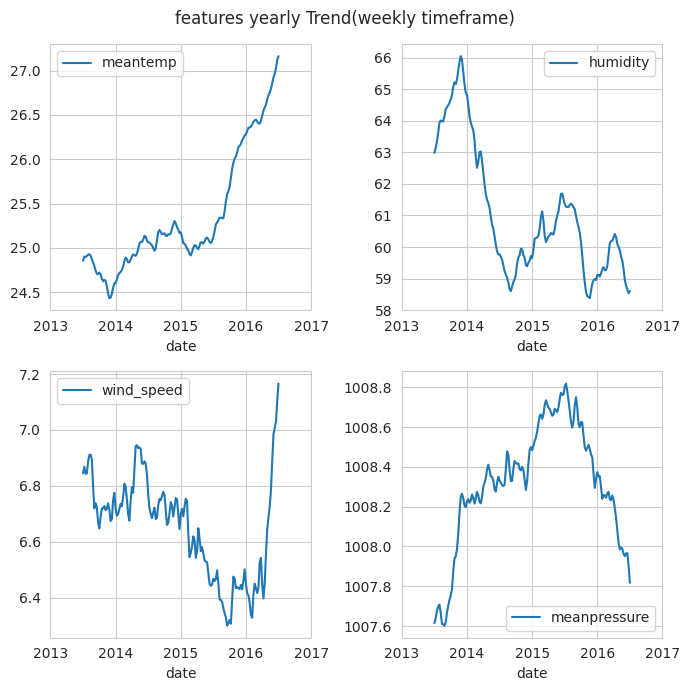

In [18]:
# plot seasonality for all cols
fig,ax =plt.subplots(nrows=2,ncols=2,figsize=(7,7))

for ax,col in zip(ax.flat,df_weekly.columns):
  decompose=seasonal_decompose(df_weekly[col])
  decompose.trend.plot(ax=ax,label=col)
  ax.legend()
  plt.tight_layout()
  plt.suptitle('features yearly Trend(weekly timeframe)')


- Temperature is rising → Possible climate change effect.
- Humidity is dropping → Could indicate drier conditions.
- Wind speed is highly variable → Likely seasonal variations or extreme events.
- Pressure peaked and then dropped → Might signal changes in weather systems

## Create new features

In [19]:
df['Day'] =df.index.day
df['Month'] =df.index.month
df['Year'] =df.index.year
df['dayofweek']=df.index.dayofweek

In [20]:
df.head()

,meantemp,humidity,wind_speed,meanpressure,Day,Month,Year,dayofweek
date,,,,,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667,1,1,2013,1
2013-01-02,7.400000,92.000000,2.980000,1017.800000,2,1,2013,2
2013-01-03,7.166667,87.000000,4.633333,1018.666667,3,1,2013,3
2013-01-04,8.666667,71.333333,1.233333,1017.166667,4,1,2013,4
2013-01-05,6.000000,86.833333,3.700000,1016.500000,5,1,2013,5


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1462 entries, 2013-01-01 to 2017-01-01
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      1462 non-null   float64
 1   humidity      1462 non-null   float64
 2   wind_speed    1462 non-null   float64
 3   meanpressure  1462 non-null   float64
 4   Day           1462 non-null   int32  
 5   Month         1462 non-null   int32  
 6   Year          1462 non-null   int32  
 7   dayofweek     1462 non-null   int32  
dtypes: float64(4), int32(4)
memory usage: 112.2 KB


### Ploting temprature over years by month

<Axes: title={'center': 'Temprature over years'}, xlabel='Month', ylabel='meantemp'>

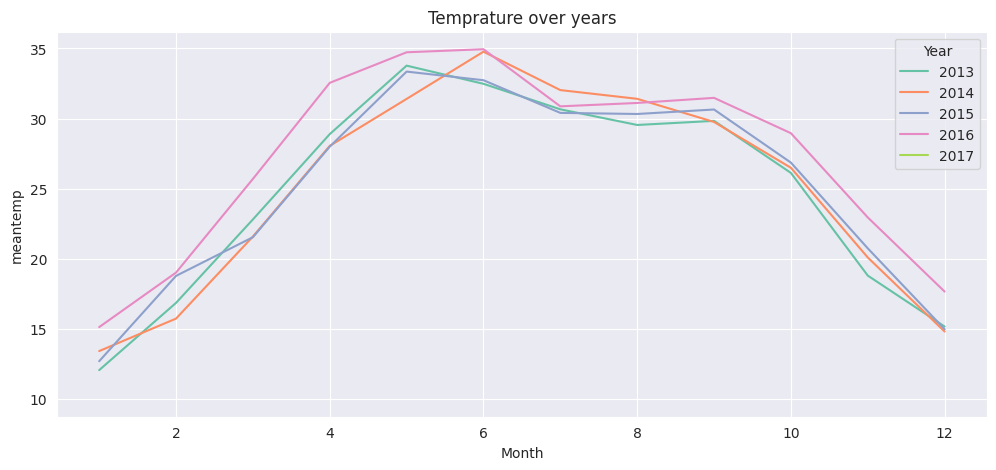

In [22]:
plt.figure(figsize=(12,5))
sns.set_style('darkgrid')
plt.title('Temprature over years')
sns.lineplot(data =df,x='Month',y ='meantemp',hue='Year',palette='Set2',ci=None)

- Seasonal Trend: Temperature rises from winter (Jan–Feb), peaks in summer (June–July), and drops toward year-end.
- 2016 was the hottest year, with peak temperatures exceeding 35°C.
- 2013 & 2017 were cooler years, showing lower overall temperatures.

### ARIMA-SARIMA Models
- ARIMA : Non-seasonal Autoregressive Integrated Moving Averages

- SARIMA : Seasonal ARIMA

- SARIMAX : Seasonal ARIMA with exogenous variables

If a time series, has seasonal patterns, then we need to add seasonal terms and it becomes SARIMA, short for Seasonal ARIMA.

### Steps for building ARIMA-SARIMA models:¶¶
1. Check Stationarity: Verify the stationarity of each series using tests like ADF (Augmented Dickey-Fuller) and KPSS (Kwiatkowski-Phillips-Schmidt-Shin). Display with ACF and PACF plots.

2. Make Series Stationary: Apply transformations to make the target and exogenous variables stationary if needed. Common methods include differencing and log transformations.

3. Model the Relationship: Use the stationary series in your ARIMA or SARIMA model.

- For ARIMA (AutoRegressive Integrated Moving Average) and SARIMA (Seasonal AutoRegressive Integrated Moving Average) models, it is essential to make the time series data stationary before fitting the model. These models assume that the time series data is stationary, meaning that its statistical properties such as mean, variance, and autocorrelation structure do not change over time. If the data is non-stationary, it can lead to biased parameter estimates and unreliable forecasts.

To make the data stationary, you typically need to remove trends and seasonality. This can be done through techniques like taking differences (for removing trends) and seasonal differencing (for removing seasonality). Once the data is stationary, you can then fit the ARIMA or SARIMA model to the transformed data.

### Check Stationary
ACF and PACF

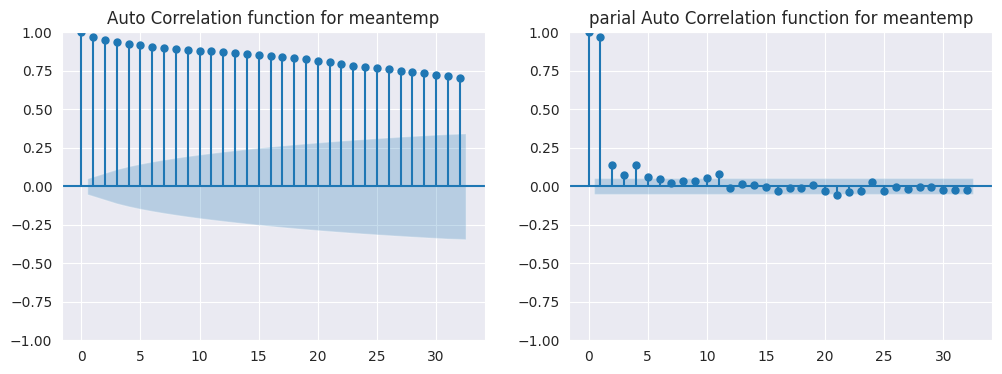

In [23]:
fig,ax =plt.subplots(nrows=1,ncols=2,figsize=(12,4))
plot_acf(df['meantemp'],title='Auto Correlation function for meantemp',ax=ax[0])
plot_pacf(df['meantemp'],title='parial Auto Correlation function for meantemp',ax=ax[1])
plt.show()

- If the series is stationary:

  - The ACF plot drops to near zero quickly after a few lags.
  - The PACF plot shows a sharp cutoff (significant values only for a few initial lags, then nearly zero).

  **insights**
  
  The Series does not seem stationary, ACF has to become 0 at some point. But we are not certainly sure yet.


## ADF and KPSS
To confirm the visual assessments of stationarity (due to trend and seasonality), the Dickey-Fuller and KPSS hypothesis tests are used:

**Augmented Dickey-Fuller Test (ADF)**

- Null Hypothesis H0: The series is not stationary
- Alternative Hypothesis H1: The series is stationary

**Kwiatkowski-Phillips-Schmidt-Shin Test (KPSS)**

- Null Hypothesis H0: The series is stationary
- Alternative Hypothesis H1: The series is not stationary

In [24]:
def check_sationary(series):
  print(f'------------check sationary for {series.name}')

  # ADF Test
  adf_test =adfuller(series.values)
  print(f"ADF Test:\n Adf statistics:{adf_test[0]}")
  print(f'ADF p_value:{adf_test[1]}')
  print('Critical Values:')

  for key,value in adf_test[4].items():
    print(f"key:{key}, value:{value}")
    if (adf_test[1] <= 0.05):
        print("Series is Stationary (ADF Test)")
    else:
        print("Series is Non-stationary (ADF Test)")

  print('\n' + '-'*50 + '\n')

  # KPSS Test
  kpss_test = kpss(series.values, regression='c', nlags='auto')
  print('KPSS Test:\n')
  print(f'KPSS Statistic: {kpss_test[0]}')
  print(f'p-value:{ kpss_test[1]}')
  print('Critical Values:')
  for key, value in kpss_test[3].items():
      print('\t%s: %.3f' % (key, value))

  if kpss_test[1] > 0.05:
      print("Series is Stationary (KPSS Test)")
  else:
      print("Series is Non-stationary (KPSS Test)")

In [25]:
check_sationary(df['meantemp'])
check_sationary(df['wind_speed'])
check_sationary(df['humidity'])
check_sationary(df['meanpressure'])

------------check sationary for meantemp
ADF Test:
 Adf statistics:-2.021069055920673
ADF p_value:0.2774121372301602
Critical Values:
key:1%, value:-3.4348647527922824
Series is Non-stationary (ADF Test)
key:5%, value:-2.863533960720434
Series is Non-stationary (ADF Test)
key:10%, value:-2.567831568508802
Series is Non-stationary (ADF Test)

--------------------------------------------------

KPSS Test:

KPSS Statistic: 0.18786352260533618
p-value:0.1
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
Series is Stationary (KPSS Test)
------------check sationary for wind_speed
ADF Test:
 Adf statistics:-3.838096756685102
ADF p_value:0.0025407221531464283
Critical Values:
key:1%, value:-3.434908816804013
Series is Stationary (ADF Test)
key:5%, value:-2.863553406963303
Series is Stationary (ADF Test)
key:10%, value:-2.5678419239852994
Series is Stationary (ADF Test)

--------------------------------------------------

KPSS Test:

KPSS Statistic: 0.13773363518932444
p-value:0.

**observations**
- meantemp     --> trend-stationary (stationary around a deterministic trend)
- meanpressure --> trend-stationary (stationary around a deterministic trend)
- humidity     --> Stationary
- wind_speed   --> Stationary


### Methods to make a time series stationary:
Among the methods to make a time series stationary, differencing and detrending are two of the most common:

1. Differencing: Taking the difference between consecutive observations helps remove trends and make the series stationary. This method is simple and often effective, especially for time series with a linear trend.

2. Detrending: Removing a trend from the time series data is another common approach. This can involve fitting a regression model to the data and subtracting the trend component, or using other techniques like polynomial regression or moving averages to remove trend effects.

These methods are widely used because they are relatively straightforward to implement and can effectively address trend-related non-stationarity in time series data.

**Other methods**
1. Seasonal Differencing: Similar to differencing, but instead of taking differences between consecutive observations, take differences between observations separated by the seasonal period.

2. Transformation: Apply mathematical transformations to stabilize the variance or make the data more linear. Common transformations include taking the logarithm, square root, or Box-Cox transformation.

3. Smoothing: Apply moving averages or exponential smoothing to remove noise and smooth out the data.

4. Decomposition: Decompose the time series into its trend, seasonal, and residual components, and then remove the trend and seasonal components.

5. Regression: Fit a regression model with exogenous variables (if available) to the time series data and remove the effect of these variables.

These methods can be applied individually or in combination, depending on the characteristics of the time series and the specific goals of the analysis. Experimentation and domain knowledge often play a crucial role in selecting the most appropriate method(s) for making a time series stationary.

In [26]:
# I will apply differencing
df['meantemp_diff'] =df['meantemp'].diff().fillna(0)
# check stationary after applying differencing
check_sationary(df['meantemp_diff'])

------------check sationary for meantemp_diff
ADF Test:
 Adf statistics:-16.294070115924345
ADF p_value:3.3160864328179846e-29
Critical Values:
key:1%, value:-3.4348616379354793
Series is Stationary (ADF Test)
key:5%, value:-2.8635325860671696
Series is Stationary (ADF Test)
key:10%, value:-2.567830836482784
Series is Stationary (ADF Test)

--------------------------------------------------

KPSS Test:

KPSS Statistic: 0.18949327124525503
p-value:0.1
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
Series is Stationary (KPSS Test)


In [27]:
# apply differencing for meanpressure
df['meanpressure_diff'] =df['meanpressure'].diff().fillna(0)
check_sationary(df['meanpressure_diff'])

------------check sationary for meanpressure_diff
ADF Test:
 Adf statistics:-17.16129717168403
ADF p_value:6.839006252650599e-30
Critical Values:
key:1%, value:-3.4348647527922824
Series is Stationary (ADF Test)
key:5%, value:-2.863533960720434
Series is Stationary (ADF Test)
key:10%, value:-2.567831568508802
Series is Stationary (ADF Test)

--------------------------------------------------

KPSS Test:

KPSS Statistic: 0.06002461969291022
p-value:0.1
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
Series is Stationary (KPSS Test)


- All series now are stationary

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1462 entries, 2013-01-01 to 2017-01-01
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   meantemp           1462 non-null   float64
 1   humidity           1462 non-null   float64
 2   wind_speed         1462 non-null   float64
 3   meanpressure       1462 non-null   float64
 4   Day                1462 non-null   int32  
 5   Month              1462 non-null   int32  
 6   Year               1462 non-null   int32  
 7   dayofweek          1462 non-null   int32  
 8   meantemp_diff      1462 non-null   float64
 9   meanpressure_diff  1462 non-null   float64
dtypes: float64(6), int32(4)
memory usage: 135.1 KB


 ### ARIMA-SARIMA with Daily data

In [29]:
# split data into train and test
train_size =int(len(df)*0.8)
train, test =df.iloc[:train_size],df.iloc[train_size:]
train.shape,test.shape

((1169, 10), (293, 10))

Error:65.64916215618689


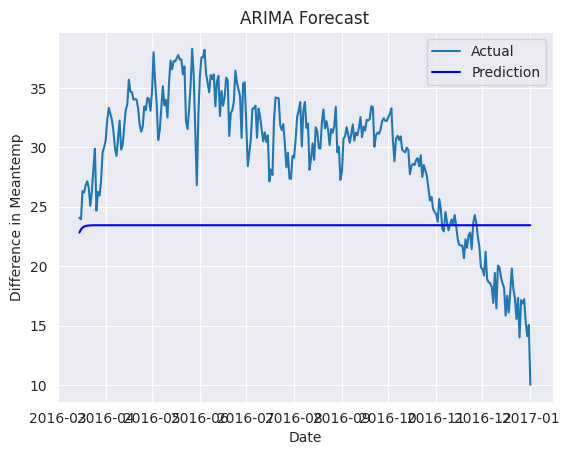

In [30]:
# Arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# First Arima Model
arima_model =ARIMA(train['meantemp'],order=(1,1,1))
arima_model_fit =arima_model.fit()

# make predictions
arima_pred =arima_model_fit.forecast(steps=len(test))

# calculate error
error =mean_squared_error(test['meantemp'],arima_pred)
print(f'Error:{error}')


# plot actual and prediction
plt.plot(test['meantemp'].index,test['meantemp'],label='Actual')
plt.plot(test['meantemp'].index,arima_pred,label='Prediction',c='b')
plt.xlabel('Date')
plt.ylabel('Difference in Meantemp')
plt.title('ARIMA Forecast')
plt.legend()
plt.show()


**simple ARIMA Model is not suitable for this data (There is seasonality in our data)**

Test MSE: 21.645150506572904
Test R²: 0.324


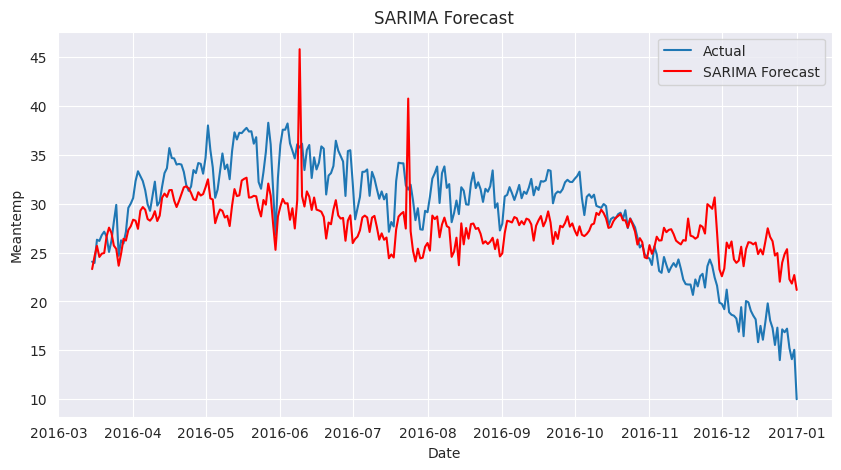

In [31]:
# SARIMAX

from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define sarima model parameters
order =(1,1,6) # Non Seasonal order
seasonal_order =(1,1,1,7)  # 7 ---> for weekly seasonality

# Fit SARIMA Model
sarima_model =SARIMAX(endog=train['meantemp'],exog=train[['humidity','wind_speed','meanpressure']],order=order,seasonal_order=seasonal_order)
sarima_fit =sarima_model.fit()

# make prediction
sarima_pred =sarima_fit.predict(start=test.index[0],end=test.index[-1] ,exog=test[['humidity','wind_speed','meanpressure']])

# Calculate error
mse = mean_squared_error(test['meantemp'], sarima_pred)
r2 = r2_score(test['meantemp'], sarima_pred)
print('Test MSE:', mse)
print('Test R²: %.3f' % r2)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(test.index, test['meantemp'], label='Actual')
plt.plot(test.index, sarima_pred, color='red', label='SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Meantemp')
plt.title('SARIMA Forecast')
plt.legend()
plt.show()




Test MSE: 23.046132078180285
Test R²: 0.280


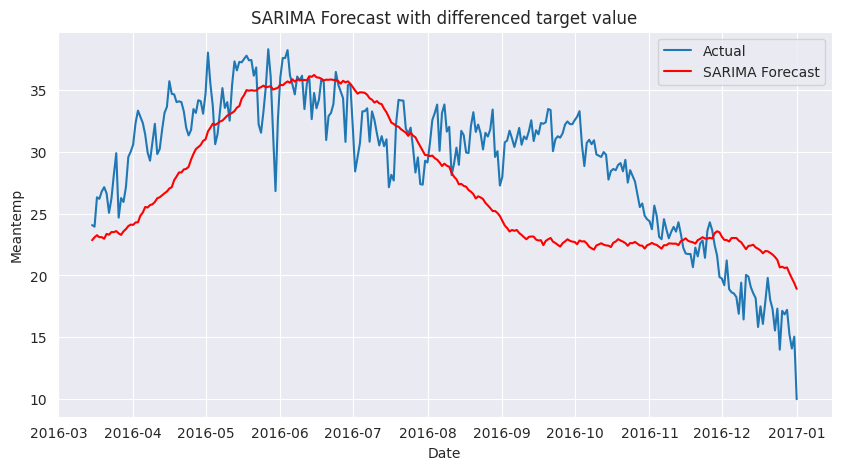

In [32]:
# SARIMAX with differenced target (will not be compared with other models)

# Fit the SARIMA model
sarima_model = SARIMAX(endog=train['meantemp_diff'], exog=train[['humidity', 'wind_speed']],
                       order=order, seasonal_order=seasonal_order)
sarima_model_fit = sarima_model.fit()

# Make predictions
sarima_pred_diff = sarima_model_fit.predict(start=test.index[0], end=test.index[-1],
                                            exog=test[['humidity', 'wind_speed']])

# Convert differenced predictions back to the original scale
# Start the conversion from the last known original value in the training set
last_original_value = train['meantemp'].iloc[-1]
sarima_pred = sarima_pred_diff.cumsum() + last_original_value

# Calculate error
mse = mean_squared_error(test['meantemp'], sarima_pred)
r2 = r2_score(test['meantemp'], sarima_pred)
print('Test MSE:', mse)
print('Test R²: %.3f' % r2)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(test.index, test['meantemp'], label='Actual')
plt.plot(test.index, sarima_pred, color='red', label='SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Meantemp')
plt.title('SARIMA Forecast with differenced target value')
plt.legend()
plt.show()

 ## Prophet Model
Prophet algorithm works with the "ds" and "y" variables as inputs. We will adjust our training and test sets accordingly.

- ds: This column contains the dates. In Prophet, the dates in this column are typically in daily frequency, although this is not mandatory. The dates can be in the format YYYY-MM-DD (e.g., "2021-01-01") or in timestamp format.

- y: This column contains the observed values you want to predict. For example, if you want to forecast the daily number of visitors to a website, the "y" column will contain these visitor numbers.

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnkiybxvb/noe6fb5s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnkiybxvb/f6_9zl_m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50422', 'data', 'file=/tmp/tmpnkiybxvb/noe6fb5s.json', 'init=/tmp/tmpnkiybxvb/f6_9zl_m.json', 'output', 'file=/tmp/tmpnkiybxvb/prophet_modelcu0pz23r/prophet_model-20250322215317.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:53:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:53:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Test MSE: 7.338
Test R²: 0.771


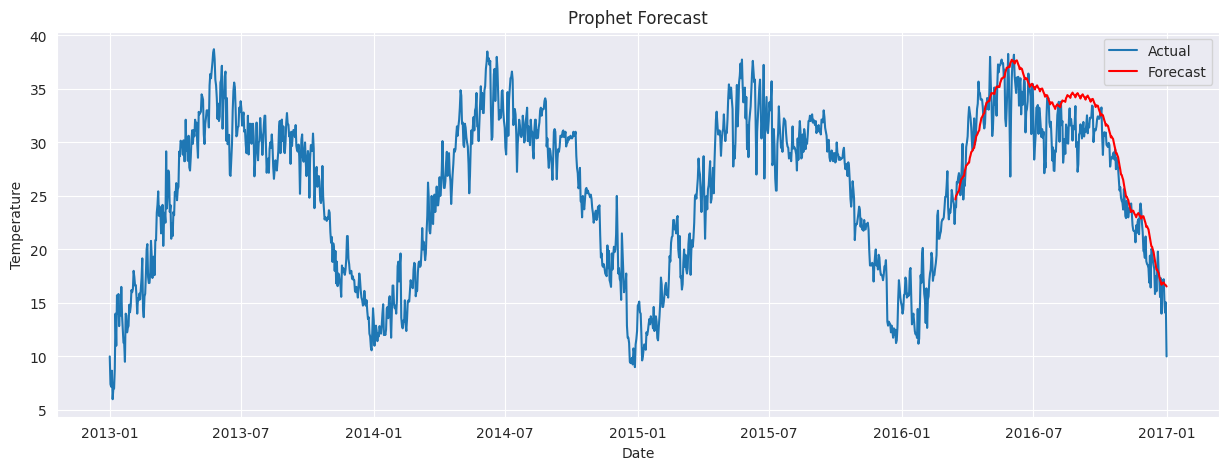

In [33]:
from prophet import Prophet
# rename columns for prophet
df_prophet = df.reset_index().rename(columns ={'date':'ds','meantemp':'y'})

# split data into train , test
train_size =int(len(df_prophet)*0.8)
p_train,p_test =df_prophet[:train_size],df_prophet[train_size:]

# Initialize and fit the Prophet model with additional features
prop_model = Prophet()

prop_model.fit(p_train)

# Make future dataframe and include additional features
future = prop_model.make_future_dataframe(periods=len(p_test), freq='D')

# Make predictions
forecast = prop_model.predict(future)

# Extract the forecasted values for the test period
predicted = forecast[['ds', 'yhat']].set_index('ds').loc[p_test['ds']]

# Calculate error and R²
mse = mean_squared_error(p_test['y'], predicted['yhat'])
r2 = r2_score(p_test['y'], predicted['yhat'])
print('Test MSE: %.3f' % mse)
print('Test R²: %.3f' % r2)

# Plot the results
plt.figure(figsize=(15, 5))
plt.plot(df_prophet['ds'], df_prophet['y'], label='Actual')
plt.plot(predicted.index, predicted['yhat'], color='red', label='Forecast')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Prophet Forecast')
plt.legend()
plt.show()


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnkiybxvb/6thfo7ho.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnkiybxvb/wm7lmz8p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60220', 'data', 'file=/tmp/tmpnkiybxvb/6thfo7ho.json', 'init=/tmp/tmpnkiybxvb/wm7lmz8p.json', 'output', 'file=/tmp/tmpnkiybxvb/prophet_modelqop2r9ey/prophet_model-20250322215318.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:53:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:53:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Test MSE: 2.775
Test R²: 0.913


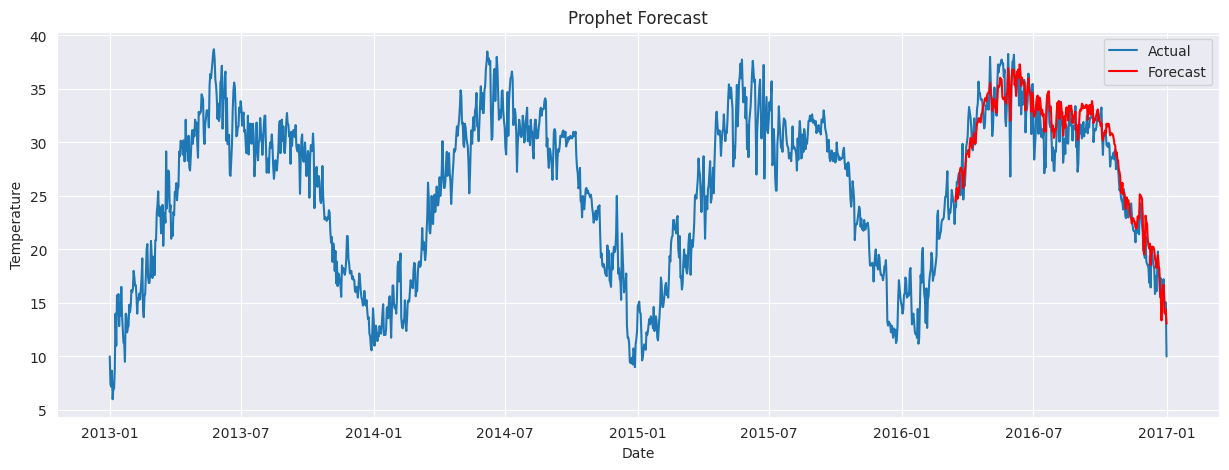

In [34]:
# Rename columns for Prophet
df_prophet = df.reset_index().rename(columns={'date': 'ds', 'meantemp': 'y'})

# Split the data into training and testing sets
train_size = int(len(df_prophet) * 0.8)
p_train, p_test = df_prophet.iloc[:train_size], df_prophet.iloc[train_size:]


# Initialize and fit the Prophet model with additional features
prop_model = Prophet()
prop_model.add_regressor('humidity')
prop_model.add_regressor('wind_speed')

prop_model.fit(p_train)


# Make future dataframe and include additional features
future = prop_model.make_future_dataframe(periods=len(p_test), freq='D')
future['humidity'] = df['humidity'].values
future['wind_speed'] = df['wind_speed'].values

# Make predictions
forecast = prop_model.predict(future)

# Extract the forecasted values for the test period
predicted = forecast[['ds', 'yhat']].set_index('ds').loc[p_test['ds']]


# Calculate error and R²
mse = mean_squared_error(p_test['y'], predicted['yhat'])
r2 = r2_score(p_test['y'], predicted['yhat'])
print('Test MSE: %.3f' % mse)
print('Test R²: %.3f' % r2)

# Plot the results
plt.figure(figsize=(15, 5))
plt.plot(df_prophet['ds'], df_prophet['y'], label='Actual')
plt.plot(predicted.index, predicted['yhat'], color='red', label='Forecast')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Prophet Forecast')
plt.legend()
plt.show()

**observation**
- The Prophet model achieved an R² score of ~91% when using the entire dataset with all features, indicating a high level of accuracy.

- In contrast, the R² score dropped to 77% when the model was trained without the additional features.

### Data Preprocessing Before Deep Learning Models

In [35]:
df.head()

,meantemp,humidity,wind_speed,meanpressure,Day,Month,Year,dayofweek,meantemp_diff,meanpressure_diff
date,,,,,,,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667,1,1,2013,1,0.000000,0.000000
2013-01-02,7.400000,92.000000,2.980000,1017.800000,2,1,2013,2,-2.600000,2.133333
2013-01-03,7.166667,87.000000,4.633333,1018.666667,3,1,2013,3,-0.233333,0.866667
2013-01-04,8.666667,71.333333,1.233333,1017.166667,4,1,2013,4,1.500000,-1.500000
2013-01-05,6.000000,86.833333,3.700000,1016.500000,5,1,2013,5,-2.666667,-0.666667


**Feature slelection**

<Axes: >

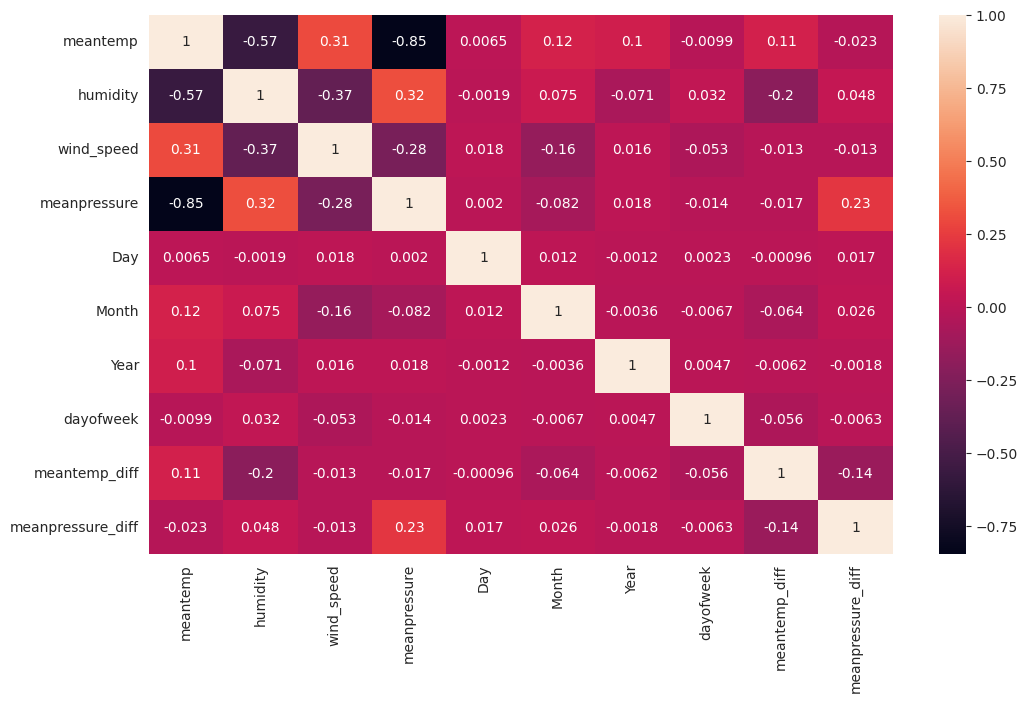

In [36]:
plt.figure(figsize=(12,7))
sns.heatmap(df.corr(),annot=True)

**observations**

I decided to continue with the 4 features for modelling: meantemp(target), humidity, wind_speed ,meanpressure

In [37]:
df_dl =df[['humidity','meantemp','meanpressure','wind_speed']]
df_dl.head()

,humidity,meantemp,meanpressure,wind_speed
date,,,,
2013-01-01,84.500000,10.000000,1015.666667,0.000000
2013-01-02,92.000000,7.400000,1017.800000,2.980000
2013-01-03,87.000000,7.166667,1018.666667,4.633333
2013-01-04,71.333333,8.666667,1017.166667,1.233333
2013-01-05,86.833333,6.000000,1016.500000,3.700000


### Scaling

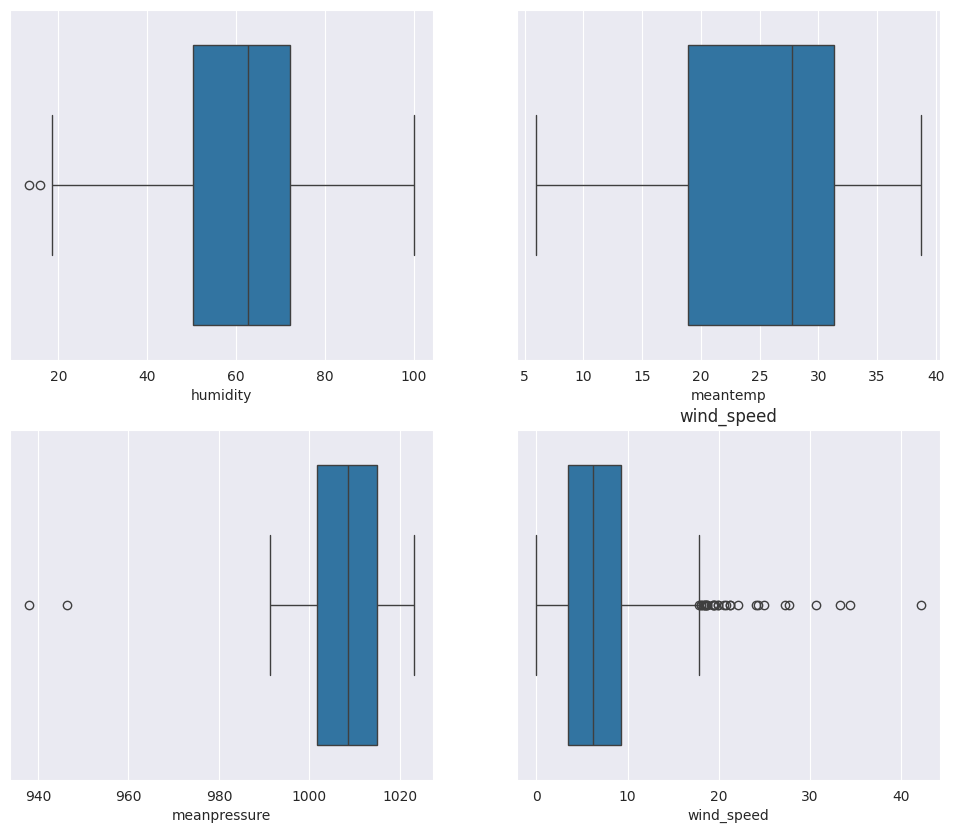

In [38]:
# find out what scaling to perform

fig,ax = plt.subplots(nrows =2,ncols =2,figsize=(12,10))
ax=ax.flatten()
i=0
for col in (df_dl.columns):
   sns.boxplot(df,x=col,ax=ax[i])
   plt.title(f'{col}')
   i+=1
plt.show()

Applying:

- MinMax scaling for meantemp ,humidity and meanpressure
scaling the target meantemp separately
- Robust scaling for wind_speed

In [39]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler

robust_scaler = RobustScaler()   # scaler for wind_speed
minmax_scaler = MinMaxScaler()  # scaler for humidity,meantemp,meanpressure

df_dl['wind_speed'] = robust_scaler.fit_transform(df_dl[['wind_speed']])  # robust for wind_speed
df_dl[['humidity','meantemp','meanpressure']] = minmax_scaler.fit_transform(df_dl[['humidity','meantemp','meanpressure']])

df_dl.head()


,humidity,meantemp,meanpressure,wind_speed
date,,,,
2013-01-01,0.820957,0.122271,0.913658,-1.079544
2013-01-02,0.907591,0.042795,0.938776,-0.562473
2013-01-03,0.849835,0.035662,0.948980,-0.275598
2013-01-04,0.668867,0.081514,0.931319,-0.865544
2013-01-05,0.847910,0.000000,0.923469,-0.437544


###  SimpleRNN Model
- Univariate
- Multivariate

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.callbacks import EarlyStopping

# create x and y with window 5
def df_to_xy (df):
  # convert dataframe into numpy array
  data =df.to_numpy()
  data =data.reshape(-1,1)
  x,y =[],[]
  ws =5

  for i in range(ws,len(data)):
    x.append(data[i-ws:i,0:1])
    y.append(data[i,0])

  x=np.array(x)
  y=np.array(y)

  return x,y


x,y =df_to_xy(df_dl['meantemp'])
x.shape,y.shape

((1457, 5, 1), (1457,))

# Split Train & Test

In [41]:
# Split the data into training and testing sets
x_train ,y_train =x[:1100] ,y[:1100]
x_val,y_val =x[1100:1200],y[1100:1200]
x_test,y_test =x[1200:],y[1200:]
x_train.shape,y_train.shape,x_val.shape,y_val.shape,x_test.shape,y_test.shape

((1100, 5, 1), (1100,), (100, 5, 1), (100,), (257, 5, 1), (257,))

In [42]:
# build Model
rnn_model= Sequential()

rnn_model.add(SimpleRNN(100, activation='tanh', input_shape=(x_train.shape[1], x_train.shape[2])))
rnn_model.add(Dense(1))

# compile
rnn_model.compile(optimizer='adam', loss='mse')

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = rnn_model.fit(x_train, y_train, epochs=30, validation_data=(x_val, y_val), batch_size=1, callbacks=[early_stopping])

# Evaluate the model
loss = rnn_model.evaluate(x_test, y_test)
print(f'Validation Loss: {loss}')

Epoch 1/30
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0073 - val_loss: 0.0027
Epoch 2/30
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0031 - val_loss: 0.0047
Epoch 3/30
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 4/30
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0033 - val_loss: 0.0024
Epoch 5/30
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0032 - val_loss: 0.0027
Epoch 6/30
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 7/30
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 8/30
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0031 - val_loss: 0.0025
Epoch 9/30
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0032 - val_loss: 0.0023
Epoch 10/30
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 11/30
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0032 - val_loss: 0.0036
Epoch 12/30
1100/1100 ━━━━━━━━

In [43]:
rnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 100)                 │          10,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,905 (120.73 KB)

 Trainable params: 10,301 (40.24 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,604 (80.49 KB)

In [44]:
# Make predictions
rnn_pred = rnn_model.predict(x_test)
# Inverse transform the true values for comparison
y_test = y_test.reshape(-1, 1)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [45]:
# Calculate RMSE and R2 scores
rmse = np.sqrt(mean_squared_error(y_test, rnn_pred))
r2 = r2_score(y_test, rnn_pred)

print(f'RMSE: {rmse}')
print(f'R2 Score: {r2}')

RMSE: 0.050418247975049055
R2 Score: 0.9221754411596771


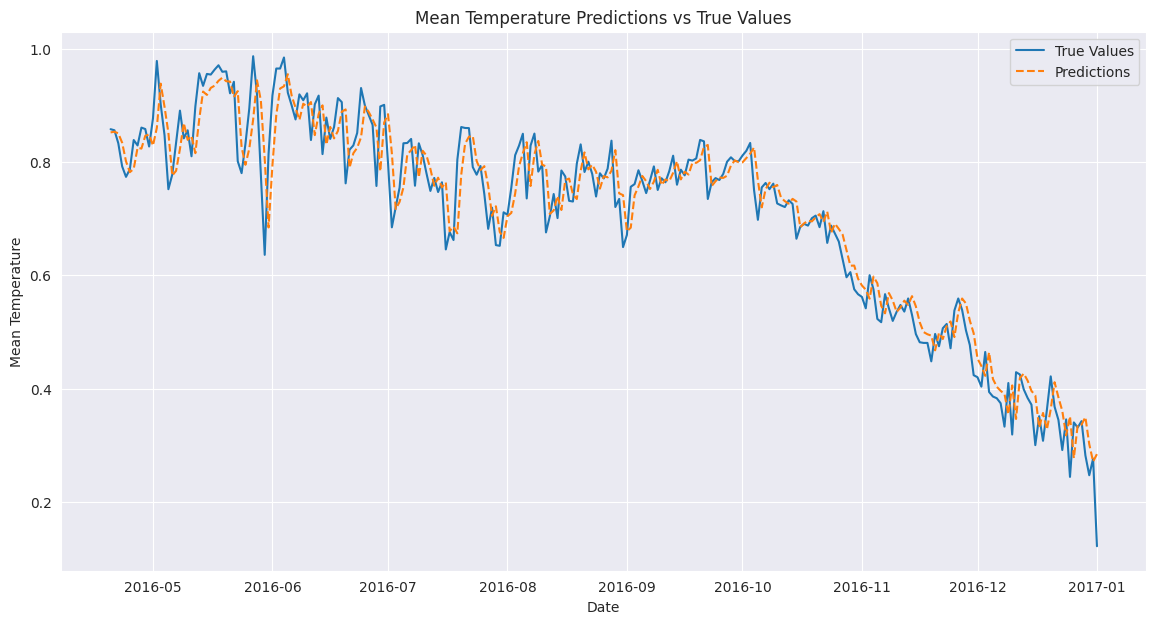

In [46]:
# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(df.index[-len(y_test):], y_test, label='True Values')
plt.plot(df.index[-len(y_test):], rnn_pred, label='Predictions', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Mean Temperature')
plt.title('Mean Temperature Predictions vs True Values')
plt.legend()
plt.show()

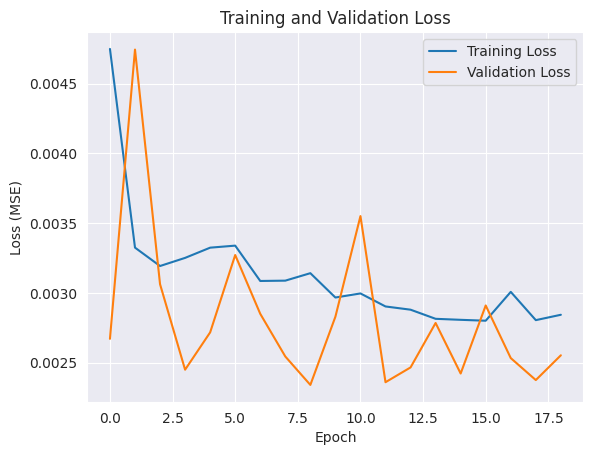

In [47]:
# Get training and validation losses from history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plot loss values over epochs
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

### LSTM Model

In [48]:
from tensorflow.keras.layers import LSTM

# Build the LSTM model
lstm_model=Sequential()
lstm_model.add(LSTM(64,input_shape=(x_train.shape[1],1)))
lstm_model.add(Dense(8,'relu'))
lstm_model.add(Dense(1,'linear'))


lstm_model.compile(optimizer='adam', loss='mse')

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = lstm_model.fit(x_train, y_train, epochs=30, validation_data=(x_val, y_val), batch_size=1, callbacks=[early_stopping])

Epoch 1/30
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0524 - val_loss: 0.0061
Epoch 2/30
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0053 - val_loss: 0.0042
Epoch 3/30
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0047 - val_loss: 0.0054
Epoch 4/30
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0044 - val_loss: 0.0037
Epoch 5/30
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0036 - val_loss: 0.0041
Epoch 6/30
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0036 - val_loss: 0.0041
Epoch 7/30
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 8/30
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 9/30
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 10/30
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0030 - val_loss: 0.0045
Epoch 11/30
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 12/30
1100/1100 ━━━━━━━━

In [49]:
lstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │             520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 52,277 (204.21 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 34,852 (136.14 KB)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
RMSE: 0.05052296071612244
R2 Score: 0.9218518406502214


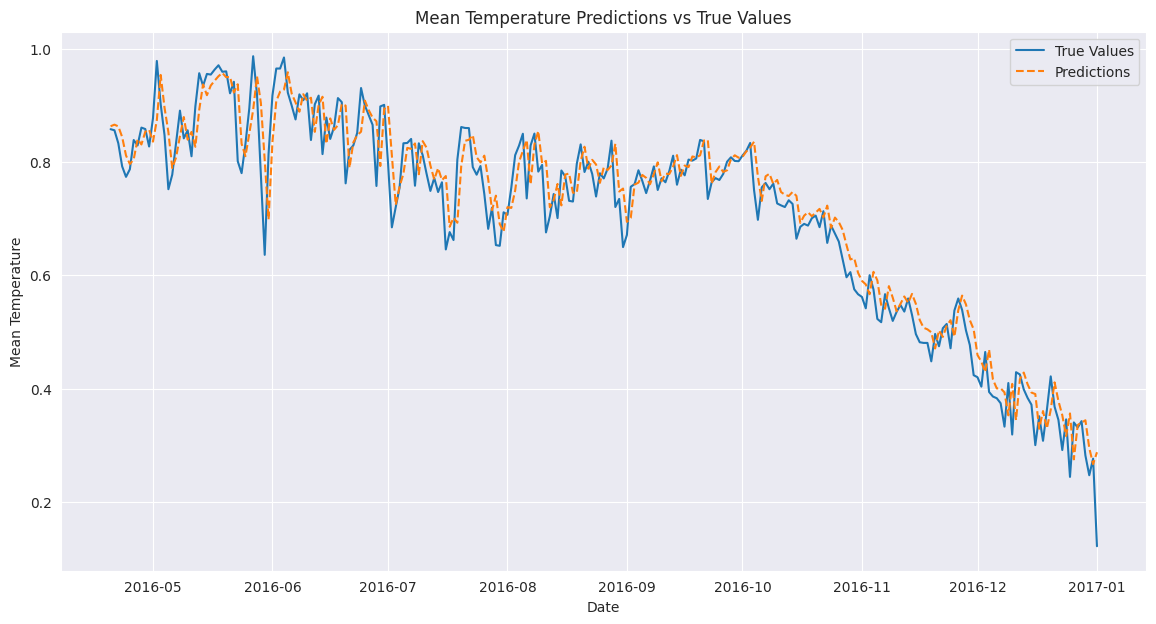

In [50]:
# Make predictions
lstm_pred = lstm_model.predict(x_test)
y_test = y_test.reshape(-1, 1)

# Calculate RMSE and R2 scores
rmse = np.sqrt(mean_squared_error(y_test, lstm_pred))
r2 = r2_score(y_test, lstm_pred)

print(f'RMSE: {rmse}')
print(f'R2 Score: {r2}')

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(df.index[-len(y_test):], y_test, label='True Values')
plt.plot(df.index[-len(y_test):], lstm_pred, label='Predictions', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Mean Temperature')
plt.title('Mean Temperature Predictions vs True Values')
plt.legend()
plt.show()

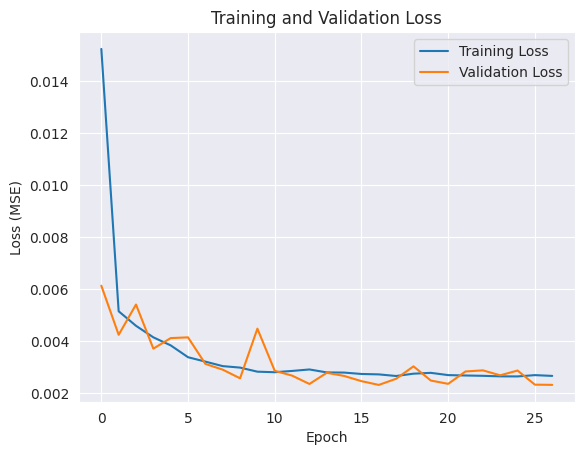

In [51]:
# Get training and validation losses from history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plot loss values over epochs
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Multivariate Bidirectional LSTM

In [52]:
# convert dataframe into x and y
def convert_xy_2(df):
    X=[]
    Y=[]
    ws = 6
    for i in range(ws,len(df)):
        x=df.iloc[i-ws:i,:]
        y =df.iloc[i,1]

        X.append(x)
        Y.append(y)

    return np.array(X),np.array(Y)


x,y =convert_xy_2(df_dl)
x.shape,y.shape

((1456, 6, 4), (1456,))

In [53]:
# split data into train & test & validation
x2_train ,y2_train=x[:1100],y[:1100]
x2_val ,y2_val=x[1100:1200],y[1100: 1200]
x2_test ,y2_test=x[ 1200:],y[1200:]
x2_train.shape, y2_train.shape, x2_val.shape, y2_val.shape, x2_test.shape, y2_test.shape

((1100, 6, 4), (1100,), (100, 6, 4), (100,), (256, 6, 4), (256,))

In [54]:
from tensorflow.keras.layers import LSTM, Bidirectional

# Build the bidirectional LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(100, activation='tanh', input_shape=( x2_train.shape[1], x2_train.shape[2]))))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(x2_train, y2_train, epochs=30, validation_data=(x2_test, y2_test), batch_size=1, callbacks=[early_stopping])

# Evaluate the model
loss = model.evaluate(x2_test, y2_test)
print(f'Validation Loss: {loss}')

Epoch 1/30
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - loss: 0.0117 - val_loss: 0.0033
Epoch 2/30
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0046 - val_loss: 0.0042
Epoch 3/30
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0036 - val_loss: 0.0070
Epoch 4/30
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0039 - val_loss: 0.0034
Epoch 5/30
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 6/30
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0035 - val_loss: 0.0030
Epoch 7/30
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0031 - val_loss: 0.0079
Epoch 8/30
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0032 - val_loss: 0.0054
Epoch 9/30
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 10/30
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0026 - val_loss: 0.0028
Epoch 11/30
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 12/30
1100/1100 ━━

In [55]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (1, 200)                    │          84,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (1, 1)                      │             201 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 252,605 (986.74 KB)

 Trainable params: 84,201 (328.91 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 168,404 (657.83 KB)

In [56]:
# Make predictions
bilstm_pred = model.predict(x2_test)
y2_test = y2_test.reshape(-1, 1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  


RMSE: 0.049804997634124375
R2 Score: 0.9241507086851011


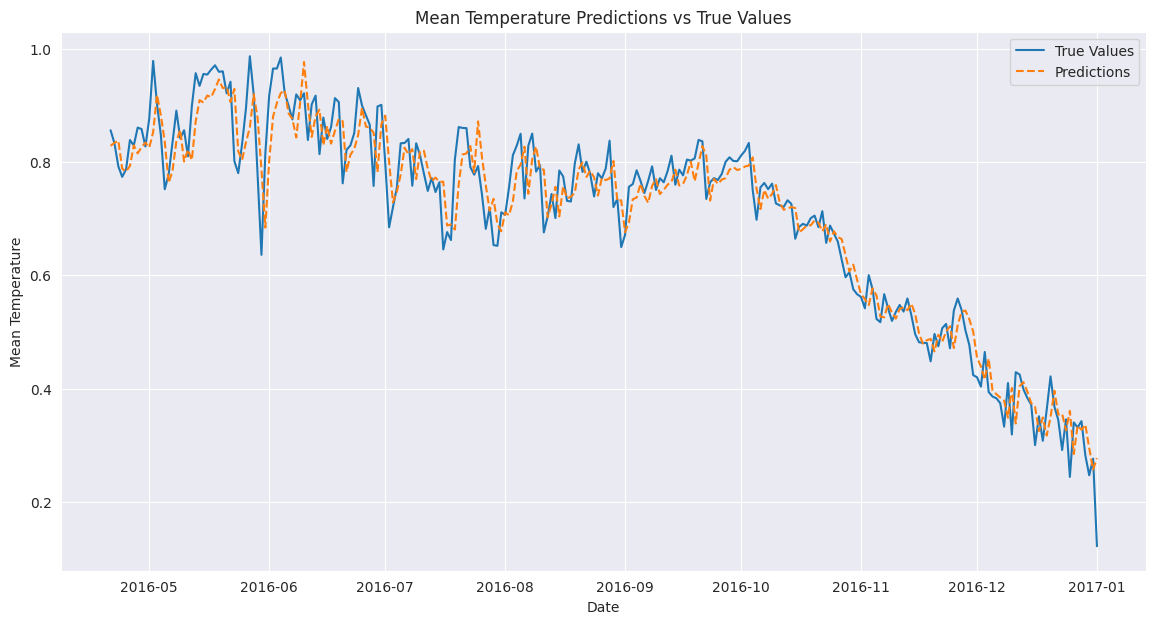

In [57]:
# Calculate RMSE and R2 scores
rmse = np.sqrt(mean_squared_error(y2_test, bilstm_pred))
r2 = r2_score(y2_test, bilstm_pred)

print(f'RMSE: {rmse}')
print(f'R2 Score: {r2}')

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(df.index[-len(y2_test):], y2_test, label='True Values')
plt.plot(df.index[-len(y2_test):], bilstm_pred, label='Predictions', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Mean Temperature')
plt.title('Mean Temperature Predictions vs True Values')
plt.legend()
plt.show()

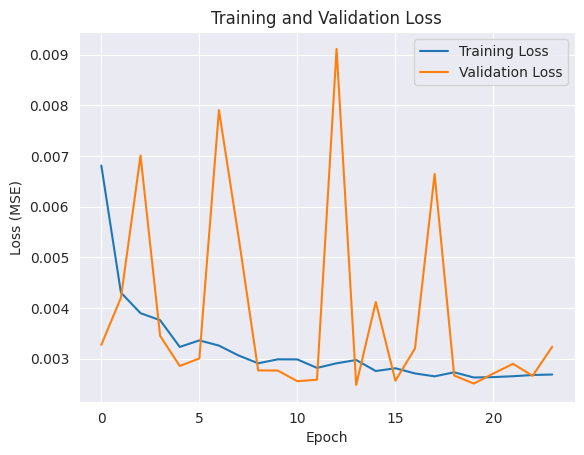

In [58]:
# Get training and validation losses from history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plot loss values over epochs
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

After exploring various time series models in detail and leveraging advanced visualizations, I've concluded that Prophet is my preferred choice among the other models. Despite testing over 6 models in a multivariate time series, Prophet's simplicity, performance, and cost-effectiveness make it the standout solution.

I have found that Prophet is able to deliver comparable results to deep learning models without the complexity and resource-intensive training they require. Unlike traditional ARIMA models, it offers a user-friendly interface and requires minimal parameter tuning, making it accessible to users with varying levels of expertise. Also, Prophet's robustness to outliers and its ability to handle irregularly spaced data add to its appeal